In [91]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import roc_auc_score, roc_curve, log_loss, auc

In [92]:
def split_salary_label(df):
    """Split data from label"""
    df['salary'] = np.where(df['salary']==" 50000+.", 1, 0)
    y = df['salary']
    X = df.drop(['salary'], axis=1)
    return y, X

def one_hot_encode_factors(df):
    """One-hot encode string columns"""
    one_hot_df = pd.get_dummies(df.select_dtypes(include=['object']))
    numeric_df = df.select_dtypes(exclude=['object'])
    return numeric_df.join(one_hot_df)

def accuracy(pred, actual):
    """Returns percentage of correctly classified labels"""
    return sum(pred==actual) / len(actual)

In [129]:
# Import data and split out labels
train = pd.read_csv('data/train_data_balanced.csv')  # balanced training data
train_full = pd.read_csv('data/train_data_full.csv') # full training data
val = pd.read_csv('data/validation_set.csv')  # balanced training data
val_pos = pd.read_csv('data/validation_set_positive.csv')  # balanced training data
train_large = pd.concat([train, val_pos])
test = pd.read_csv('data/test_set.csv')

# Split into labels, names and data
y_train, X_train = split_salary_label(train)
X_train = one_hot_encode_factors(X_train)

y_train_full, X_train_full = split_salary_label(train_full)
X_train_full = one_hot_encode_factors(X_train_full)

y_val, X_val = split_salary_label(val)
X_val = one_hot_encode_factors(X_val)

y_train_large, X_train_large = split_salary_label(train_large)
X_train_large = one_hot_encode_factors(X_train_large)

y_test, X_test = split_salary_label(test)
X_test = one_hot_encode_factors(X_test)

In [94]:
# Optimize RF parameters using grid search
rf = RandomForestClassifier(criterion='entropy')
param_grid = {
    'n_estimators': [100], 
    'max_depth': [1, 5, 20],
    'max_features': [10, 20, 30],
    'n_jobs': [30],
    'min_samples_leaf': [3, 5, 10]
}

grid_rf = GridSearchCV(rf, param_grid, cv=2, verbose=3)
grid_rf.fit(X_train, y_train)
print("#-------- DONE WITH GRID SEARCH.")
best_model = grid_rf.best_estimator_
best_params = grid_rf.best_params_ 
scores = grid_rf.grid_scores_
print(best_params)

Fitting 2 folds for each of 27 candidates, totalling 54 fits
[CV] max_depth=1, max_features=10, min_samples_leaf=3, n_estimators=100, n_jobs=30 
[CV]  max_depth=1, max_features=10, min_samples_leaf=3, n_estimators=100, n_jobs=30, score=0.635095, total=   1.5s
[CV] max_depth=1, max_features=10, min_samples_leaf=3, n_estimators=100, n_jobs=30 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.2s remaining:    0.0s


[CV]  max_depth=1, max_features=10, min_samples_leaf=3, n_estimators=100, n_jobs=30, score=0.611852, total=   1.5s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100, n_jobs=30 


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    4.1s remaining:    0.0s


[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100, n_jobs=30, score=0.602935, total=   1.4s
[CV] max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100, n_jobs=30 
[CV]  max_depth=1, max_features=10, min_samples_leaf=5, n_estimators=100, n_jobs=30, score=0.624974, total=   1.3s
[CV] max_depth=1, max_features=10, min_samples_leaf=10, n_estimators=100, n_jobs=30 
[CV]  max_depth=1, max_features=10, min_samples_leaf=10, n_estimators=100, n_jobs=30, score=0.645268, total=   1.3s
[CV] max_depth=1, max_features=10, min_samples_leaf=10, n_estimators=100, n_jobs=30 
[CV]  max_depth=1, max_features=10, min_samples_leaf=10, n_estimators=100, n_jobs=30, score=0.602342, total=   1.3s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=100, n_jobs=30 
[CV]  max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=100, n_jobs=30, score=0.728450, total=   1.4s
[CV] max_depth=1, max_features=20, min_samples_leaf=3, n_estimators=100, n_jobs=30 
[

[Parallel(n_jobs=1)]: Done  54 out of  54 | elapsed:  4.4min finished


#-------- DONE WITH GRID SEARCH.
{'max_depth': 20, 'max_features': 30, 'min_samples_leaf': 3, 'n_estimators': 100, 'n_jobs': 30}


/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/model_selection/_search.py:667: DeprecationWarning: The grid_scores_ attribute was deprecated in version 0.18 in favor of the more elaborate cv_results_ attribute. The grid_scores_ attribute will not be available from 0.20
  DeprecationWarning)


In [132]:
rf = RandomForestClassifier(n_estimators=500, criterion='entropy', max_features=30, max_depth=20,
	                            min_samples_leaf=3, bootstrap=True, oob_score=True, n_jobs=30, random_state=0)
# rf = rf.fit(X_train_full, y_train_full)
rf = rf.fit(X_train, y_train)

In [133]:
y_val_pred = rf.predict(X_val)
y_val_prob = rf.predict_proba(X_val)
print("Validation Accuracy = %f" % accuracy(y_val_pred, y_val))
print("Log loss = %f" % log_loss(y_val, y_val_prob))
print("AUC ROC score = %f" % roc_auc_score(y_val, [p[1] for p in y_val_prob]))

Validation Accuracy = 0.906459
Log loss = 0.215784
AUC ROC score = 0.944962


In [125]:
# rf = rf.fit(X_train_large, y_train_large)

JoblibValueError: JoblibValueError
___________________________________________________________________________
Multiprocessing exception:
...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/runpy.py in _run_module_as_main(mod_name='ipykernel.__main__', alter_argv=1)
    188         sys.exit(msg)
    189     main_globals = sys.modules["__main__"].__dict__
    190     if alter_argv:
    191         sys.argv[0] = mod_spec.origin
    192     return _run_code(code, main_globals, None,
--> 193                      "__main__", mod_spec)
        mod_spec = ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py')
    194 
    195 def run_module(mod_name, init_globals=None,
    196                run_name=None, alter_sys=False):
    197     """Execute a module's code without importing it

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/runpy.py in _run_code(code=<code object <module> at 0x10f6478a0, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>, run_globals={'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/danielfriar/anaconda3/lib/python3.6/site-...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/danie.../python3.6/site-packages/ipykernel/kernelapp.py'>}, init_globals=None, mod_name='__main__', mod_spec=ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), pkg_name='ipykernel', script_name=None)
     80                        __cached__ = cached,
     81                        __doc__ = None,
     82                        __loader__ = loader,
     83                        __package__ = pkg_name,
     84                        __spec__ = mod_spec)
---> 85     exec(code, run_globals)
        code = <code object <module> at 0x10f6478a0, file "/Use...3.6/site-packages/ipykernel/__main__.py", line 1>
        run_globals = {'__annotations__': {}, '__builtins__': <module 'builtins' (built-in)>, '__cached__': '/Users/danielfriar/anaconda3/lib/python3.6/site-...ges/ipykernel/__pycache__/__main__.cpython-36.pyc', '__doc__': None, '__file__': '/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py', '__loader__': <_frozen_importlib_external.SourceFileLoader object>, '__name__': '__main__', '__package__': 'ipykernel', '__spec__': ModuleSpec(name='ipykernel.__main__', loader=<_f...b/python3.6/site-packages/ipykernel/__main__.py'), 'app': <module 'ipykernel.kernelapp' from '/Users/danie.../python3.6/site-packages/ipykernel/kernelapp.py'>}
     86     return run_globals
     87 
     88 def _run_module_code(code, init_globals=None,
     89                     mod_name=None, mod_spec=None,

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/__main__.py in <module>()
      1 
      2 
----> 3 
      4 if __name__ == '__main__':
      5     from ipykernel import kernelapp as app
      6     app.launch_new_instance()
      7 
      8 
      9 
     10 

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/traitlets/config/application.py in launch_instance(cls=<class 'ipykernel.kernelapp.IPKernelApp'>, argv=None, **kwargs={})
    653 
    654         If a global instance already exists, this reinitializes and starts it
    655         """
    656         app = cls.instance(**kwargs)
    657         app.initialize(argv)
--> 658         app.start()
        app.start = <bound method IPKernelApp.start of <ipykernel.kernelapp.IPKernelApp object>>
    659 
    660 #-----------------------------------------------------------------------------
    661 # utility functions, for convenience
    662 #-----------------------------------------------------------------------------

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/kernelapp.py in start(self=<ipykernel.kernelapp.IPKernelApp object>)
    469             return self.subapp.start()
    470         if self.poller is not None:
    471             self.poller.start()
    472         self.kernel.start()
    473         try:
--> 474             ioloop.IOLoop.instance().start()
    475         except KeyboardInterrupt:
    476             pass
    477 
    478 launch_new_instance = IPKernelApp.launch_instance

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/zmq/eventloop/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    172             )
    173         return loop
    174     
    175     def start(self):
    176         try:
--> 177             super(ZMQIOLoop, self).start()
        self.start = <bound method ZMQIOLoop.start of <zmq.eventloop.ioloop.ZMQIOLoop object>>
    178         except ZMQError as e:
    179             if e.errno == ETERM:
    180                 # quietly return on ETERM
    181                 pass

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/tornado/ioloop.py in start(self=<zmq.eventloop.ioloop.ZMQIOLoop object>)
    882                 self._events.update(event_pairs)
    883                 while self._events:
    884                     fd, events = self._events.popitem()
    885                     try:
    886                         fd_obj, handler_func = self._handlers[fd]
--> 887                         handler_func(fd_obj, events)
        handler_func = <function wrap.<locals>.null_wrapper>
        fd_obj = <zmq.sugar.socket.Socket object>
        events = 1
    888                     except (OSError, IOError) as e:
    889                         if errno_from_exception(e) == errno.EPIPE:
    890                             # Happens when the client closes the connection
    891                             pass

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=(<zmq.sugar.socket.Socket object>, 1), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = (<zmq.sugar.socket.Socket object>, 1)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_events(self=<zmq.eventloop.zmqstream.ZMQStream object>, fd=<zmq.sugar.socket.Socket object>, events=1)
    435             # dispatch events:
    436             if events & IOLoop.ERROR:
    437                 gen_log.error("got POLLERR event on ZMQStream, which doesn't make sense")
    438                 return
    439             if events & IOLoop.READ:
--> 440                 self._handle_recv()
        self._handle_recv = <bound method ZMQStream._handle_recv of <zmq.eventloop.zmqstream.ZMQStream object>>
    441                 if not self.socket:
    442                     return
    443             if events & IOLoop.WRITE:
    444                 self._handle_send()

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _handle_recv(self=<zmq.eventloop.zmqstream.ZMQStream object>)
    467                 gen_log.error("RECV Error: %s"%zmq.strerror(e.errno))
    468         else:
    469             if self._recv_callback:
    470                 callback = self._recv_callback
    471                 # self._recv_callback = None
--> 472                 self._run_callback(callback, msg)
        self._run_callback = <bound method ZMQStream._run_callback of <zmq.eventloop.zmqstream.ZMQStream object>>
        callback = <function wrap.<locals>.null_wrapper>
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    473                 
    474         # self.update_state()
    475         
    476 

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/zmq/eventloop/zmqstream.py in _run_callback(self=<zmq.eventloop.zmqstream.ZMQStream object>, callback=<function wrap.<locals>.null_wrapper>, *args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    409         close our socket."""
    410         try:
    411             # Use a NullContext to ensure that all StackContexts are run
    412             # inside our blanket exception handler rather than outside.
    413             with stack_context.NullContext():
--> 414                 callback(*args, **kwargs)
        callback = <function wrap.<locals>.null_wrapper>
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    415         except:
    416             gen_log.error("Uncaught exception, closing connection.",
    417                           exc_info=True)
    418             # Close the socket on an uncaught exception from a user callback

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/tornado/stack_context.py in null_wrapper(*args=([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],), **kwargs={})
    270         # Fast path when there are no active contexts.
    271         def null_wrapper(*args, **kwargs):
    272             try:
    273                 current_state = _state.contexts
    274                 _state.contexts = cap_contexts[0]
--> 275                 return fn(*args, **kwargs)
        args = ([<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>],)
        kwargs = {}
    276             finally:
    277                 _state.contexts = current_state
    278         null_wrapper._wrapped = True
    279         return null_wrapper

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatcher(msg=[<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>])
    271         if self.control_stream:
    272             self.control_stream.on_recv(self.dispatch_control, copy=False)
    273 
    274         def make_dispatcher(stream):
    275             def dispatcher(msg):
--> 276                 return self.dispatch_shell(stream, msg)
        msg = [<zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>, <zmq.sugar.frame.Frame object>]
    277             return dispatcher
    278 
    279         for s in self.shell_streams:
    280             s.on_recv(make_dispatcher(s), copy=False)

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in dispatch_shell(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, msg={'buffers': [], 'content': {'allow_stdin': True, 'code': 'rf = rf.fit(X_train_large, y_train_large)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-07-19T14:01:05.731244', 'msg_id': 'FFF739EEB1A941528EF30DBAEDC569A3', 'msg_type': 'execute_request', 'session': 'AEF3AE1B3BA5489A8985BA6B80B2D25F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FFF739EEB1A941528EF30DBAEDC569A3', 'msg_type': 'execute_request', 'parent_header': {}})
    223             self.log.error("UNKNOWN MESSAGE TYPE: %r", msg_type)
    224         else:
    225             self.log.debug("%s: %s", msg_type, msg)
    226             self.pre_handler_hook()
    227             try:
--> 228                 handler(stream, idents, msg)
        handler = <bound method Kernel.execute_request of <ipykernel.ipkernel.IPythonKernel object>>
        stream = <zmq.eventloop.zmqstream.ZMQStream object>
        idents = [b'AEF3AE1B3BA5489A8985BA6B80B2D25F']
        msg = {'buffers': [], 'content': {'allow_stdin': True, 'code': 'rf = rf.fit(X_train_large, y_train_large)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-07-19T14:01:05.731244', 'msg_id': 'FFF739EEB1A941528EF30DBAEDC569A3', 'msg_type': 'execute_request', 'session': 'AEF3AE1B3BA5489A8985BA6B80B2D25F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FFF739EEB1A941528EF30DBAEDC569A3', 'msg_type': 'execute_request', 'parent_header': {}}
    229             except Exception:
    230                 self.log.error("Exception in message handler:", exc_info=True)
    231             finally:
    232                 self.post_handler_hook()

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/kernelbase.py in execute_request(self=<ipykernel.ipkernel.IPythonKernel object>, stream=<zmq.eventloop.zmqstream.ZMQStream object>, ident=[b'AEF3AE1B3BA5489A8985BA6B80B2D25F'], parent={'buffers': [], 'content': {'allow_stdin': True, 'code': 'rf = rf.fit(X_train_large, y_train_large)', 'silent': False, 'stop_on_error': True, 'store_history': True, 'user_expressions': {}}, 'header': {'date': '2017-07-19T14:01:05.731244', 'msg_id': 'FFF739EEB1A941528EF30DBAEDC569A3', 'msg_type': 'execute_request', 'session': 'AEF3AE1B3BA5489A8985BA6B80B2D25F', 'username': 'username', 'version': '5.0'}, 'metadata': {}, 'msg_id': 'FFF739EEB1A941528EF30DBAEDC569A3', 'msg_type': 'execute_request', 'parent_header': {}})
    385         if not silent:
    386             self.execution_count += 1
    387             self._publish_execute_input(code, parent, self.execution_count)
    388 
    389         reply_content = self.do_execute(code, silent, store_history,
--> 390                                         user_expressions, allow_stdin)
        user_expressions = {}
        allow_stdin = True
    391 
    392         # Flush output before sending the reply.
    393         sys.stdout.flush()
    394         sys.stderr.flush()

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/ipkernel.py in do_execute(self=<ipykernel.ipkernel.IPythonKernel object>, code='rf = rf.fit(X_train_large, y_train_large)', silent=False, store_history=True, user_expressions={}, allow_stdin=True)
    191 
    192         self._forward_input(allow_stdin)
    193 
    194         reply_content = {}
    195         try:
--> 196             res = shell.run_cell(code, store_history=store_history, silent=silent)
        res = undefined
        shell.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = 'rf = rf.fit(X_train_large, y_train_large)'
        store_history = True
        silent = False
    197         finally:
    198             self._restore_input()
    199 
    200         if res.error_before_exec is not None:

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/ipykernel/zmqshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, *args=('rf = rf.fit(X_train_large, y_train_large)',), **kwargs={'silent': False, 'store_history': True})
    496             )
    497         self.payload_manager.write_payload(payload)
    498 
    499     def run_cell(self, *args, **kwargs):
    500         self._last_traceback = None
--> 501         return super(ZMQInteractiveShell, self).run_cell(*args, **kwargs)
        self.run_cell = <bound method ZMQInteractiveShell.run_cell of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        args = ('rf = rf.fit(X_train_large, y_train_large)',)
        kwargs = {'silent': False, 'store_history': True}
    502 
    503     def _showtraceback(self, etype, evalue, stb):
    504         # try to preserve ordering of tracebacks and print statements
    505         sys.stdout.flush()

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_cell(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, raw_cell='rf = rf.fit(X_train_large, y_train_large)', store_history=True, silent=False, shell_futures=True)
   2712                 self.displayhook.exec_result = result
   2713 
   2714                 # Execute the user code
   2715                 interactivity = "none" if silent else self.ast_node_interactivity
   2716                 has_raised = self.run_ast_nodes(code_ast.body, cell_name,
-> 2717                    interactivity=interactivity, compiler=compiler, result=result)
        interactivity = 'last_expr'
        compiler = <IPython.core.compilerop.CachingCompiler object>
   2718                 
   2719                 self.last_execution_succeeded = not has_raised
   2720 
   2721                 # Reset this so later displayed values do not modify the

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_ast_nodes(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, nodelist=[<_ast.Assign object>], cell_name='<ipython-input-125-192224a7b482>', interactivity='none', compiler=<IPython.core.compilerop.CachingCompiler object>, result=<ExecutionResult object at 11cbc4860, execution_..._before_exec=None error_in_exec=None result=None>)
   2816 
   2817         try:
   2818             for i, node in enumerate(to_run_exec):
   2819                 mod = ast.Module([node])
   2820                 code = compiler(mod, cell_name, "exec")
-> 2821                 if self.run_code(code, result):
        self.run_code = <bound method InteractiveShell.run_code of <ipykernel.zmqshell.ZMQInteractiveShell object>>
        code = <code object <module> at 0x11f4e7810, file "<ipython-input-125-192224a7b482>", line 1>
        result = <ExecutionResult object at 11cbc4860, execution_..._before_exec=None error_in_exec=None result=None>
   2822                     return True
   2823 
   2824             for i, node in enumerate(to_run_interactive):
   2825                 mod = ast.Interactive([node])

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py in run_code(self=<ipykernel.zmqshell.ZMQInteractiveShell object>, code_obj=<code object <module> at 0x11f4e7810, file "<ipython-input-125-192224a7b482>", line 1>, result=<ExecutionResult object at 11cbc4860, execution_..._before_exec=None error_in_exec=None result=None>)
   2876         outflag = 1  # happens in more places, so it's easier as default
   2877         try:
   2878             try:
   2879                 self.hooks.pre_run_code_hook()
   2880                 #rprint('Running code', repr(code_obj)) # dbg
-> 2881                 exec(code_obj, self.user_global_ns, self.user_ns)
        code_obj = <code object <module> at 0x11f4e7810, file "<ipython-input-125-192224a7b482>", line 1>
        self.user_global_ns = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np\nimport pandas as pd\nimport ma...chCV\nfrom sklearn.metrics import confusion_matrix', "# Import data and split out labels\ntrain = pd.re...train.drop(['class', 'name', 'sequence'], axis=1)", "# Import data and split out labels\ntrain = pd.re...salary']\nX_train = train.drop(['salary'], axis=1)", 'len(val)', "# Import data and split out labels\ntrain = pd.re...salary']\nX_train = train.drop(['salary'], axis=1)", 'len(train_full)', 'len(train)', 'len(y_train[y_train[\'salary\'] == " 50000+."]) / len(y_train)', 'y_train[y_train[\'salary\'] == " 50000+."]', 'y_train.head()', 'import numpy as np\nimport pandas as pd\nimport ma...ix\nfrom sklearn.preprocessing import LabelEncoder', 'train.loc[:, train.dtypes == str]', '# train.loc[:, train.dtypes == str]\ntrain.dtypes', '# train.loc[:, train.dtypes == str]\ntrain.dtypes == str', '# train.loc[:, train.dtypes == str]\ntrain.dtypes == Str', '# train.loc[:, train.dtypes == str]\ntrain.dtypes == str', '# train.loc[:, train.dtypes == str]\ntrain.head()', "# train.loc[:, train.dtypes == str]\ntrain.head()\ntrain.select_dtypes(include=['str'])", "# train.loc[:, train.dtypes == str]\ntrain.head()\ntrain.select_dtypes(include=['float64'])", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {4: 49074, 6: 147220, 7: 106093, 10: 0     - 50000.
1     - 50000.
2     - 50000.
3  ...50000.
4     - 50000.
Name: salary, dtype: object, 12: Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, ..., 96, 97, 98, 99, ...]

[106093 rows x 0 columns], 13: Unnamed: 0                                      ...                             object
dtype: object, 14: Unnamed: 0                                    Fa...                                False
dtype: bool, 16: Unnamed: 0                                    Fa...                                False
dtype: bool, 17:    Unnamed: 0  age   class_of_worker  industry_c...      0    95   - 50000.  

[5 rows x 43 columns], 19:         detailed_household_summary_in_household
...               1276.56

[106093 rows x 1 columns], ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_test':        Unnamed: 0  age  industry_code  occupatio...                  0  

[98769 rows x 361 columns], 'X_train':         Unnamed: 0  age  industry_code  occupati...                 0  

[114616 rows x 361 columns], 'X_train_full':         Unnamed: 0  age  industry_code  occupati...                 0  

[147045 rows x 361 columns], 'X_train_large':         Unnamed: 0  age  industry_code  occupati...                 0  

[123871 rows x 361 columns], ...}
        self.user_ns = {'ExtraTreesClassifier': <class 'sklearn.ensemble.forest.ExtraTreesClassifier'>, 'GridSearchCV': <class 'sklearn.model_selection._search.GridSearchCV'>, 'In': ['', 'import numpy as np\nimport pandas as pd\nimport ma...chCV\nfrom sklearn.metrics import confusion_matrix', "# Import data and split out labels\ntrain = pd.re...train.drop(['class', 'name', 'sequence'], axis=1)", "# Import data and split out labels\ntrain = pd.re...salary']\nX_train = train.drop(['salary'], axis=1)", 'len(val)', "# Import data and split out labels\ntrain = pd.re...salary']\nX_train = train.drop(['salary'], axis=1)", 'len(train_full)', 'len(train)', 'len(y_train[y_train[\'salary\'] == " 50000+."]) / len(y_train)', 'y_train[y_train[\'salary\'] == " 50000+."]', 'y_train.head()', 'import numpy as np\nimport pandas as pd\nimport ma...ix\nfrom sklearn.preprocessing import LabelEncoder', 'train.loc[:, train.dtypes == str]', '# train.loc[:, train.dtypes == str]\ntrain.dtypes', '# train.loc[:, train.dtypes == str]\ntrain.dtypes == str', '# train.loc[:, train.dtypes == str]\ntrain.dtypes == Str', '# train.loc[:, train.dtypes == str]\ntrain.dtypes == str', '# train.loc[:, train.dtypes == str]\ntrain.head()', "# train.loc[:, train.dtypes == str]\ntrain.head()\ntrain.select_dtypes(include=['str'])", "# train.loc[:, train.dtypes == str]\ntrain.head()\ntrain.select_dtypes(include=['float64'])", ...], 'LabelEncoder': <class 'sklearn.preprocessing.label.LabelEncoder'>, 'Out': {4: 49074, 6: 147220, 7: 106093, 10: 0     - 50000.
1     - 50000.
2     - 50000.
3  ...50000.
4     - 50000.
Name: salary, dtype: object, 12: Empty DataFrame
Columns: []
Index: [0, 1, 2, 3, ..., 96, 97, 98, 99, ...]

[106093 rows x 0 columns], 13: Unnamed: 0                                      ...                             object
dtype: object, 14: Unnamed: 0                                    Fa...                                False
dtype: bool, 16: Unnamed: 0                                    Fa...                                False
dtype: bool, 17:    Unnamed: 0  age   class_of_worker  industry_c...      0    95   - 50000.  

[5 rows x 43 columns], 19:         detailed_household_summary_in_household
...               1276.56

[106093 rows x 1 columns], ...}, 'RandomForestClassifier': <class 'sklearn.ensemble.forest.RandomForestClassifier'>, 'X_test':        Unnamed: 0  age  industry_code  occupatio...                  0  

[98769 rows x 361 columns], 'X_train':         Unnamed: 0  age  industry_code  occupati...                 0  

[114616 rows x 361 columns], 'X_train_full':         Unnamed: 0  age  industry_code  occupati...                 0  

[147045 rows x 361 columns], 'X_train_large':         Unnamed: 0  age  industry_code  occupati...                 0  

[123871 rows x 361 columns], ...}
   2882             finally:
   2883                 # Reset our crash handler in place
   2884                 sys.excepthook = old_excepthook
   2885         except SystemExit as e:

...........................................................................
/Users/danielfriar/Desktop/projects/dk_project/<ipython-input-125-192224a7b482> in <module>()
----> 1 
      2 
      3 
      4 
      5 
      6 rf = rf.fit(X_train_large, y_train_large)
      7 
      8 
      9 
     10 

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in fit(self=RandomForestClassifier(bootstrap=True, class_wei...state=0,
            verbose=0, warm_start=False), X=array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]]), sample_weight=None)
    321             trees = Parallel(n_jobs=self.n_jobs, verbose=self.verbose,
    322                              backend="threading")(
    323                 delayed(_parallel_build_trees)(
    324                     t, self, X, y, sample_weight, i, len(trees),
    325                     verbose=self.verbose, class_weight=self.class_weight)
--> 326                 for i, t in enumerate(trees))
        i = 499
    327 
    328             # Collect newly grown trees
    329             self.estimators_.extend(trees)
    330 

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=Parallel(n_jobs=30), iterable=<generator object BaseForest.fit.<locals>.<genexpr>>)
    763             if pre_dispatch == "all" or n_jobs == 1:
    764                 # The iterable was consumed all at once by the above for loop.
    765                 # No need to wait for async callbacks to trigger to
    766                 # consumption.
    767                 self._iterating = False
--> 768             self.retrieve()
        self.retrieve = <bound method Parallel.retrieve of Parallel(n_jobs=30)>
    769             # Make sure that we get a last message telling us we are done
    770             elapsed_time = time.time() - self._start_time
    771             self._print('Done %3i out of %3i | elapsed: %s finished',
    772                         (len(self._output), len(self._output),

---------------------------------------------------------------------------
Sub-process traceback:
---------------------------------------------------------------------------
ValueError                                         Wed Jul 19 14:01:06 2017
PID: 56143            Python 3.6.0: /Users/danielfriar/anaconda3/bin/python
...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in __call__(self=<sklearn.externals.joblib.parallel.BatchedCalls object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        self.items = [(<function _parallel_build_trees>, (DecisionTreeClassifier(class_weight=None, criter...         random_state=209652396, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...state=0,
            verbose=0, warm_start=False), array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32), array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]]), None, 0, 500), {'class_weight': None, 'verbose': 0})]
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/externals/joblib/parallel.py in <listcomp>(.0=<list_iterator object>)
    126     def __init__(self, iterator_slice):
    127         self.items = list(iterator_slice)
    128         self._size = len(self.items)
    129 
    130     def __call__(self):
--> 131         return [func(*args, **kwargs) for func, args, kwargs in self.items]
        func = <function _parallel_build_trees>
        args = (DecisionTreeClassifier(class_weight=None, criter...         random_state=209652396, splitter='best'), RandomForestClassifier(bootstrap=True, class_wei...state=0,
            verbose=0, warm_start=False), array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32), array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]]), None, 0, 500)
        kwargs = {'class_weight': None, 'verbose': 0}
    132 
    133     def __len__(self):
    134         return self._size
    135 

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py in _parallel_build_trees(tree=DecisionTreeClassifier(class_weight=None, criter...         random_state=209652396, splitter='best'), forest=RandomForestClassifier(bootstrap=True, class_wei...state=0,
            verbose=0, warm_start=False), X=array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]]), sample_weight=None, tree_idx=0, n_trees=500, verbose=0, class_weight=None)
    115                 warnings.simplefilter('ignore', DeprecationWarning)
    116                 curr_sample_weight *= compute_sample_weight('auto', y, indices)
    117         elif class_weight == 'balanced_subsample':
    118             curr_sample_weight *= compute_sample_weight('balanced', y, indices)
    119 
--> 120         tree.fit(X, y, sample_weight=curr_sample_weight, check_input=False)
        tree.fit = <bound method DecisionTreeClassifier.fit of Deci...        random_state=209652396, splitter='best')>
        X = array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32)
        y = array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])
        sample_weight = None
        curr_sample_weight = array([ 1.,  1.,  2., ...,  1.,  2.,  0.])
    121     else:
    122         tree.fit(X, y, sample_weight=sample_weight, check_input=False)
    123 
    124     return tree

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=209652396, splitter='best'), X=array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]]), sample_weight=array([ 1.,  1.,  2., ...,  1.,  2.,  0.]), check_input=False, X_idx_sorted=None)
    734 
    735         super(DecisionTreeClassifier, self).fit(
    736             X, y,
    737             sample_weight=sample_weight,
    738             check_input=check_input,
--> 739             X_idx_sorted=X_idx_sorted)
        X_idx_sorted = None
    740         return self
    741 
    742 
    743     def predict_proba(self, X, check_input=True):

...........................................................................
/Users/danielfriar/anaconda3/lib/python3.6/site-packages/sklearn/tree/tree.py in fit(self=DecisionTreeClassifier(class_weight=None, criter...         random_state=209652396, splitter='best'), X=array([[  1.00000000e+00,   4.00000000e+01,   1.....00000000e+00,   0.00000000e+00]], dtype=float32), y=array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]]), sample_weight=array([ 1.,  1.,  2., ...,  1.,  2.,  0.]), check_input=False, X_idx_sorted=None)
    235 
    236         self.max_features_ = max_features
    237 
    238         if len(y) != n_samples:
    239             raise ValueError("Number of labels=%d does not match "
--> 240                              "number of samples=%d" % (len(y), n_samples))
        y = array([[ 0.],
       [ 0.],
       [ 0.],
       ..., 
       [ 1.],
       [ 1.],
       [ 1.]])
        n_samples = 123871
    241         if not 0 <= self.min_weight_fraction_leaf <= 0.5:
    242             raise ValueError("min_weight_fraction_leaf must in [0, 0.5]")
    243         if max_depth <= 0:
    244             raise ValueError("max_depth must be greater than zero. ")

ValueError: Number of labels=117701 does not match number of samples=123871
___________________________________________________________________________

In [114]:
y_test_pred = rf.predict(X_test)
y_test_prob = rf.predict_proba(X_test)
print("Test Accuracy = %f" % accuracy(y_test_pred, y_test))
print("Log loss = %f" % log_loss(y_test, y_test_prob))
print("AUC ROC score = %f" % roc_auc_score(y_test, [p[1] for p in y_test_prob]))

Test Accuracy = 0.954389
Log loss = 0.119419
AUC ROC score = 0.949653


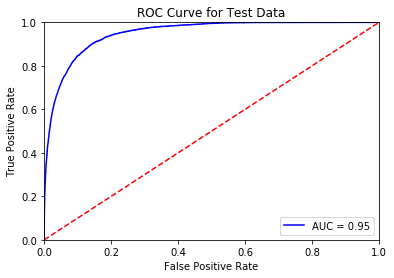

In [116]:
fpr, tpr, threshold = roc_curve(y_test, [p[1] for p in y_test_prob])
roc_auc = auc(fpr, tpr)

# method I: plt
fig = plt.figure()
plt.title('ROC Curve for Test Data')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()
# fig.savefig('figures/test_roc.png', bbox_inches='tight')

In [111]:
# Feature importance
importance = rf.feature_importances_
importance = pd.DataFrame(importance, index=X_train.columns, columns=["Importance"])
importance["stddev"] = np.std([t.feature_importances_ for t in rf.estimators_], axis=0)
importance = importance[importance['Importance']>0.01]
importance.to_csv('results/feature_importance.csv')